In [221]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

# Read in the SP500 tickers
# ssl._create_default_https_context = ssl._create_unverified_context
# table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# df = table[0]
# df.to_csv('S&P500-Info.csv', index=False)
# df.to_csv("S&P500-Symbols.csv", columns=['Symbol'], index=False)


# Alternatively, read tickers from pre-existing csv
df = pd.read_csv("S&P500-Symbols.csv")
tickers = df['Symbol']

# Fetch data
# data = yf.download(tickers,'2015-1-1')['Adj Close']

# Import SP500 index
start_date = '2014-01-01'
end_date = '2024-01-03'
spx = pd.DataFrame(yf.download('^SPX', start_date, end_date)['Adj Close'])

all_dates = pd.date_range(start_date, end_date)
spx['Price Date'] = spx.index
spx = spx.reindex(all_dates, method='bfill')

# Drop data for 2024 (we pulled it to backfill end of 2023)
spx = spx[spx.index < '2024-01-01']
# Assign year, and attach

spx['Year'] = spx.index.year
spx['Month Day'] = spx.index.strftime('%m-%d')

spx['Yr Init Price'] = spx.groupby('Year', sort=False).transform('first'
                                                                 )['Adj Close']
spx['Seasonal Trend Price'] = spx['Adj Close'] / spx['Yr Init Price'] * 100

# Now take averages over the last 10 years
spx10yr = spx.groupby('Month Day')[['Month Day','Seasonal Trend Price']].mean()
spx10yr['plot date'] = list(spx10yr.reset_index()['Month Day'].apply(
    lambda x: datetime.strptime("2000-" + x, "%Y-%m-%d")))

# Plot
fig, ax = plt.subplots()

for label, dfy in spx.assign(
        # Set to 2000 because it has Feb 29
        date=pd.to_datetime(spx.index.strftime('2000-%m-%d')),
        year=spx.index.strftime('%Y')
).groupby('year'):
    dfy.set_index('date')['Seasonal Trend Price'].plot(ax=ax, label=str(label), linewidth=1)

ax.plot(spx10yr['plot date'], spx10yr['Seasonal Trend Price'],
        label='10 year trend', linewidth=3.0, linestyle='dashed', color='black')
ax.axhline(y=100, color='blue')

locator = mdates.MonthLocator()  # every month
formatter = mdates.ConciseDateFormatter(
    locator,
    formats=['', '%b', '%d', '%H:%M', '%H:%M', '%S.%f'],
    offset_formats=['', '', '%b', '%b-%d', '%b-%d', '%b-%d %H:%M']
)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left')


[*********************100%%**********************]  1 of 1 completed


TypeError: agg function failed [how->mean,dtype->object]

[*********************100%%**********************]  1 of 1 completed


TypeError: agg function failed [how->mean,dtype->object]

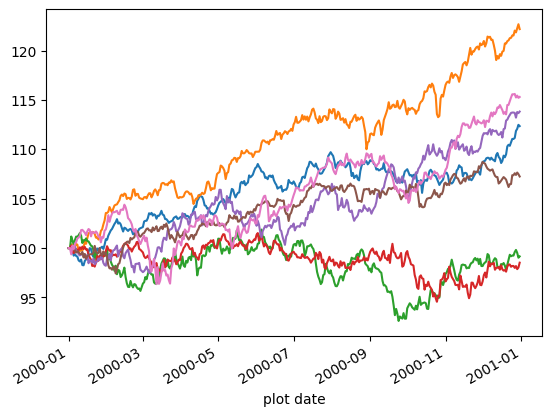

In [215]:
# Import SP500 index
start_date = '1989-01-01'
end_date = '2024-01-05'
spx = pd.DataFrame(yf.download('^SPX', start_date, end_date)['Adj Close'])

all_dates = pd.date_range(start_date, end_date)
spx['Price Date'] = spx.index
spx = spx.reindex(all_dates, method='bfill')

# Drop data for 2024 (we pulled it to backfill end of 2023)
spx = spx[spx.index < '2024-01-01']

spx['Year'] = spx.index.year
spx['Month Day'] = spx.index.strftime('%m-%d')
spx['Yr Init Price'] = spx.groupby('Year', sort=False).transform(
    'first')['Adj Close']
spx['Seasonal Trend Price'] = spx['Adj Close'] / spx['Yr Init Price'] * 100
spx['Yr Group'] = np.select(
    condlist=[spx.Year < 1994, spx.Year < 1999, spx.Year < 2004,
              spx.Year < 2009, spx.Year < 2014, spx.Year < 2019],
    choicelist=['1989-1993 Trend', '1994-1998 Trend', '1999-2003 Trend',
                '2004-2008 Trend', '2009-2013 Trend', '2014-2018 Trend'],
    default='2019-2023 Trend')

# Plot
fig, ax = plt.subplots()

spx5yr = spx.groupby(['Month Day', 'Yr Group']).mean()
spx5yr['plot date'] = list(spx5yr.reset_index()['Month Day'].apply(
    lambda x: datetime.strptime("2000-" + x, "%Y-%m-%d")))
spx5yr = spx5yr[spx5yr['plot date'] != '2000-02-29']

for label, dfy in spx5yr.groupby('Yr Group'):
    dfy.set_index('plot date')['Seasonal Trend Price'].plot(
        ax=ax, label=str(label))

# Now take averages over the last 10 years
spxavg = spx.groupby('Month Day').mean()
spxavg['plot date'] = list(spxavg.reset_index()['Month Day'].apply(
    lambda x: datetime.strptime("2000-" + x, "%Y-%m-%d")))


In [218]:

# Alternatively, read tickers from pre-existing csv
df = pd.read_csv("S&P500-Symbols.csv")
tickers = df['Symbol']

# Fetch data
# data = yf.download(tickers,'2015-1-1')['Adj Close']

# Import SP500 index
start_date = '2014-01-01'
end_date = '2024-01-03'
spx = pd.DataFrame(yf.download('^SPX', start_date, end_date)['Adj Close'])

all_dates = pd.date_range(start_date, end_date)
spx['Price Date'] = spx.index
spx = spx.reindex(all_dates, method='bfill')

# Drop data for 2024 (we pulled it to backfill end of 2023)
spx = spx[spx.index < '2024-01-01']
# Assign year, and attach

spx['Year'] = spx.index.year
spx['Month Day'] = spx.index.strftime('%m-%d')

spx['Yr Init Price'] = spx.groupby('Year', sort=False).transform('first'
                                                                 )['Adj Close']
spx['Seasonal Trend Price'] = spx['Adj Close'] / spx['Yr Init Price'] * 100

# Now take averages over the last 10 years
spx10yr = spx.groupby('Month Day').mean()

[*********************100%%**********************]  1 of 1 completed


In [219]:
spx10yr

,Adj Close,Price Date,Year,Yr Init Price,Seasonal Trend Price
Month Day,,,,,
01-01,2894.571008,2018-07-04 04:48:00,2018.5,2894.571008,100.000000
01-02,2894.571008,2018-07-04 04:48:00,2018.5,2894.571008,100.000000
01-03,2883.958997,2018-07-04 21:36:00,2018.5,2894.571008,99.559711
01-04,2898.012988,2018-07-06 00:00:00,2018.5,2894.571008,100.071404
01-05,2890.772009,2018-07-06 21:36:00,2018.5,2894.571008,99.985251
...,...,...,...,...,...
12-27,3196.480029,2019-06-28 02:24:00,2018.5,2894.571008,111.597840
12-28,3187.984033,2019-06-29 00:00:00,2018.5,2894.571008,111.334930
12-29,3195.915063,2019-06-30 00:00:00,2018.5,2894.571008,111.549434


In [48]:
tbill = pd.read_csv('Tbill.csv')


In [56]:
tbill.assign(
    year=tbill.DATE.str.slice(stop=4),
month=tbill.DATE.str.slice(start=5,stop=7))

,DATE,TB3MS,year,month
0,1989-01-01,8.27,1989,01
1,1989-02-01,8.53,1989,02
2,1989-03-01,8.82,1989,03
3,1989-04-01,8.65,1989,04
4,1989-05-01,8.43,1989,05
...,...,...,...,...
415,2023-08-01,5.30,2023,08
416,2023-09-01,5.32,2023,09
417,2023-10-01,5.34,2023,10
418,2023-11-01,5.27,2023,11


[*********************100%%**********************]  1 of 1 completed


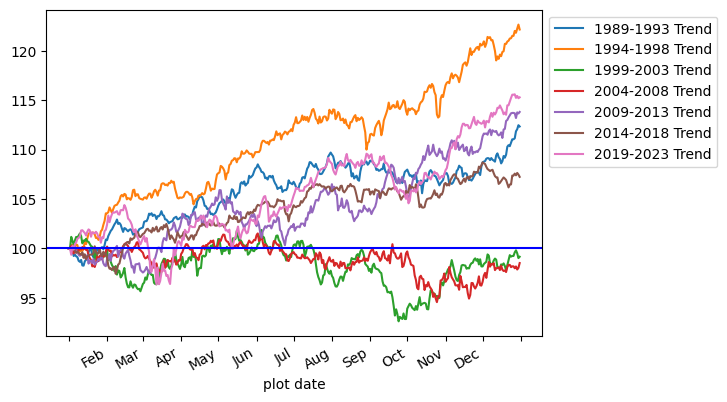

In [71]:
# Import SP500 index
start_date = '1989-01-01'
end_date = '2024-01-05'
spx = pd.DataFrame(yf.download('^SPX', start_date, end_date)['Adj Close'])

all_dates = pd.date_range(start_date, end_date)
spx['Price Date'] = spx.index
spx = spx.reindex(all_dates, method='bfill')

# Drop data for 2024 (we pulled it to backfill end of 2023)
spx = spx[spx.index < '2024-01-01']

spx['Year'] = spx.index.year
spx['Month Day'] = spx.index.strftime('%m-%d')
spx['Yr Init Price'] = spx.groupby('Year', sort=False).transform(
    'first')['Adj Close']
spx['Seasonal Trend Price'] = spx['Adj Close'] / spx['Yr Init Price'] * 100
spx['Yr Group'] = np.select(
    condlist=[spx.Year < 1994, spx.Year < 1999, spx.Year < 2004,
              spx.Year < 2009, spx.Year < 2014, spx.Year < 2019],
    choicelist=['1989-1993 Trend', '1994-1998 Trend', '1999-2003 Trend',
                '2004-2008 Trend', '2009-2013 Trend', '2014-2018 Trend'],
    default='2019-2023 Trend')

# Plot
fig, ax = plt.subplots()

spx5yr = spx.groupby(['Month Day', 'Yr Group']).mean()
spx5yr['plot date'] = list(spx5yr.reset_index()['Month Day'].apply(
    lambda x: datetime.strptime("2000-" + x, "%Y-%m-%d")))
spx5yr = spx5yr[spx5yr['plot date'] != '2000-02-29']

for label, dfy in spx5yr.groupby('Yr Group'):
    dfy.set_index('plot date')['Seasonal Trend Price'].plot(
        ax=ax, label=str(label))

locator = mdates.MonthLocator()  # every month
formatter = mdates.ConciseDateFormatter(
    locator,
    formats=['', '%b', '%d', '%H:%M', '%H:%M', '%S.%f'],
    offset_formats=['', '', '%b', '%b-%d', '%b-%d', '%b-%d %H:%M'])

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax.axhline(y=100, color='blue')

# Let's compare three strategies: investing in 3-month T-bills from January
# through March (3 mos.) and going long the SP500 from Apr-Dec,
# holding the SP500 all year, and just buying 3-month T-bills.

# "Risk-free" 3-month T-bills. Assume we buy on Jan 1 for Apr 1 maturity,
# then repeat on Apr 1 for Jul 1 maturity, Jul 1 for Oct 1, Oct 1 for Jan 1
# Tbill.csv is pulled from https://fred.stlouisfed.org/series/DTB3
tbill = pd.read_csv('Tbill.csv')
tbill['year'] = tbill.DATE.str.slice(stop=4)
tbill['month'] = tbill.DATE.str.slice(start=5, stop=7)

# Only take returns on months 1, 4, 7, 10. TB3MS is in percent, so divide
# by 100. Multiply for each month, then subtract by 1
tbill_strategy = (tbill[tbill.month.isin(['01', '04', '07', '10'])].assign(
    bondreturn=1 + tbill.TB3MS / 100
).groupby('year').bondreturn.prod() - 1).reset_index(name='T bill return')

# Only long SP500

In [95]:
def yrly_return(x):
    start_val = x[x['Month Day']=='01-01']['Adj Close'].values[0]
    end_val = x[x['Month Day']=='12-31']['Adj Close'].values[0]
    return end_val/start_val-1

sp500_strategy = spx.groupby('Year').apply(yrly_return).reset_index(name='SP500 return')
    

In [109]:
# Let's compare three strategies: investing in 3-month T-bills from January
# through March (3 mos.) and going long the SP500 from Apr-Dec,
# holding the SP500 all year, and just buying 3-month T-bills.

# "Risk-free" 3-month T-bills. Assume we buy on Jan 1 for Apr 1 maturity,
# then repeat on Apr 1 for Jul 1 maturity, Jul 1 for Oct 1, Oct 1 for Jan 1
# Tbill.csv is pulled from https://fred.stlouisfed.org/series/DTB3
tbill = pd.read_csv('Tbill.csv')
tbill['Year'] = tbill.DATE.str.slice(stop=4)
tbill['month'] = tbill.DATE.str.slice(start=5, stop=7)

# Only take returns on months 1, 4, 7, 10. TB3MS is in percent, so divide
# by 100. Multiply for each month, then subtract by 1
tbill_strategy = (tbill[tbill.month.isin(['01', '04', '07', '10'])].assign(
    bondreturn=1 + tbill.TB3MS / 100
).groupby('Year').bondreturn.prod() - 1).reset_index(name='T bill return')


# Only long SP500: buy as soon as possible after Jan 1 and sell as soon as
# possible after Dec 31
def yearly_return(x):
    start_val = x[x['Month Day'] == '01-01']['Adj Close'].values[0]
    end_val = x[x['Month Day'] == '12-31']['Adj Close'].values[0]
    return end_val / start_val - 1


sp500_strategy = spx.groupby('Year').apply(yearly_return).reset_index(
    name='SP500 return')


# Buy 3 month T-bill on Jan 1, reinvest in SP500 when it matures on Apr 1,
# close out as soon as possible after Dec 31

def april_return(x):
    start_val = x[x['Month Day'] == '04-01']['Adj Close'].values[0]
    end_val = x[x['Month Day'] == '12-31']['Adj Close'].values[0]
    return end_val / start_val - 1


april_returns = spx.groupby('Year').apply(april_return).reset_index(
    name='April onwards SP500 return')

tbill_jan_return = tbill[tbill.month == '01']


In [152]:

tbill = pd.read_csv('Tbill.csv')
tbill['Year'] = tbill.DATE.str.slice(stop=4).astype(int)
tbill['month'] = tbill.DATE.str.slice(start=5, stop=7)

# Only take returns on months 1, 4, 7, 10. TB3MS is in percent, so divide
# by 100. Multiply for each month, then subtract by 1
tbill_strategy = (tbill[tbill.month.isin(['01', '04', '07', '10'])].assign(
    bondreturn=1 + (1 + tbill.TB3MS / 4) / 100
).groupby('Year').bondreturn.prod() - 1).reset_index(name='T-bill return')


# Only long SP500: buy as soon as possible after Jan 1 and sell as soon as
# possible after Dec 31
def yearly_return(x):
    start_val = x[x['Month Day'] == '01-01']['Adj Close'].values[0]
    end_val = x[x['Month Day'] == '12-31']['Adj Close'].values[0]
    return end_val / start_val - 1


sp500_strategy = spx.groupby('Year').apply(yearly_return).reset_index(
    name='SP500 return')


# Buy 3 month T-bill on Jan 1, reinvest in SP500 when it matures on Apr 1,
# close out as soon as possible after Dec 31

def april_return(x):
    start_val = x[x['Month Day'] == '04-01']['Adj Close'].values[0]
    end_val = x[x['Month Day'] == '12-31']['Adj Close'].values[0]
    return end_val / start_val - 1


april_returns = spx.groupby('Year').apply(april_return).reset_index(
    name='April onwards SP500 return')

tbill_jan_returns = tbill[tbill.month == '01']
seasonal_strategy = april_returns.merge(tbill_jan_returns, on='Year', how='left')
seasonal_strategy['Seasonal return'] = (
        (seasonal_strategy['April onwards SP500 return'] + 1) * (
        1 + seasonal_strategy['TB3MS'] /(4 * 100) - 1))

# Compare strategies, simple Sharpe ratio
strategies = tbill_strategy[['Year', 'T-bill return']].merge(
    sp500_strategy[['Year', 'SP500 return']], on='Year').merge(
    seasonal_strategy[['Year', 'Seasonal return']], on='Year')

In [154]:
tbill_strategy

,Year,T-bill return
0,1989,0.126709
1,1990,0.120599
2,1991,0.099617
3,1992,0.076130
4,1993,0.071675
5,1994,0.082266
6,1995,0.098599
7,1996,0.093324
8,1997,0.093645
9,1998,0.090171


In [158]:
tbill[tbill['Year']==2022]

,DATE,TB3MS,Year,month
396,2022-01-01,0.15,2022,01
397,2022-02-01,0.33,2022,02
398,2022-03-01,0.44,2022,03
399,2022-04-01,0.76,2022,04
400,2022-05-01,0.98,2022,05
401,2022-06-01,1.49,2022,06
402,2022-07-01,2.23,2022,07
403,2022-08-01,2.63,2022,08
404,2022-09-01,3.13,2022,09
405,2022-10-01,3.72,2022,10


In [171]:
tbill = pd.read_csv('Tbill.csv')
tbill['Year'] = tbill.DATE.str.slice(stop=4).astype(int)
tbill['month'] = tbill.DATE.str.slice(start=5, stop=7)

# Only take returns on months 1, 4, 7, 10. TB3MS is in percent, so divide
# by 100. Multiply for each month, then subtract by 1
tbill_strategy = (tbill[tbill.month.isin(['01', '04', '07', '10'])].assign(
    bondreturn=1  + tbill.TB3MS / (4 * 100)
).groupby('Year').bondreturn.prod() - 1).reset_index(name='T-bill return')

# Only long SP500: buy as soon as possible after Jan 1 and sell as soon as
# possible after Dec 31
def yearly_return(x):
    start_val = x[x['Month Day'] == '01-01']['Adj Close'].values[0]
    end_val = x[x['Month Day'] == '12-31']['Adj Close'].values[0]
    return end_val / start_val - 1


sp500_strategy = spx.groupby('Year').apply(yearly_return).reset_index(
    name='SP500 return')


# Buy 3 month T-bill on Jan 1, reinvest in SP500 when it matures on Apr 1,
# close out as soon as possible after Dec 31

def april_return(x):
    start_val = x[x['Month Day'] == '04-01']['Adj Close'].values[0]
    end_val = x[x['Month Day'] == '12-31']['Adj Close'].values[0]
    return end_val / start_val - 1


april_returns = spx.groupby('Year').apply(april_return).reset_index(
    name='April onwards SP500 return')

tbill_jan_returns = tbill[tbill.month == '01']
seasonal_strategy = april_returns.merge(tbill_jan_returns, on='Year', how='left')
seasonal_strategy['Seasonal return'] = (
        (seasonal_strategy['April onwards SP500 return'] + 1) * (
        1 + seasonal_strategy['TB3MS'] /(4 * 100)) - 1)

# Compare strategies, simple Sharpe ratio
strategies = tbill_strategy[['Year', 'T-bill return']].merge(
    sp500_strategy[['Year', 'SP500 return']], on='Year').merge(
    seasonal_strategy[['Year', 'Seasonal return']], on='Year')

strate

In [187]:
strategies['SP500 excess']=strategies['SP500 return']-strategies['T-bill return']
strategies['Seasonal excess']=strategies['Seasonal return']-strategies['T-bill return']

In [195]:
a = strategies[strategies['Year']>2014]
a['SP500 excess'].mean()/a['SP500 excess'].std()

0.576125957819193

In [196]:
a['Seasonal excess'].mean()/a['Seasonal excess'].std()

0.535772047845307

In [205]:
def mar(x):
    start_val = x[x['Month Day'] == '01-01']['Adj Close'].values[0]
    end_val = x[x['Month Day'] == '03-01']['Adj Close'].values[0]
    return end_val / start_val - 1

In [210]:
spx.groupby('Year').apply(mar).mean()

0.004416595715872806